# Isochrone map of drive time to nearest Stroke cares in Vietnam

The project is a part of the World Bank's Disruptive Technology for Public Assets Governance (DT4PAG) supporting the Government of Vietnam. This work is done by Tuan Phan, Parvathy Krisnan, and Kai Kaiser from the World Bank.

For this blog, we will showcase the power of cloud base technology to help officials in the Vietnam's public sectors to cope with the new technology age. We use Google's Colab environment for data analytics and Google Drive as storage.

In [ ]:
#@title
!pip install geopandas pandas flask requests 2>&1 >/dev/null
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title
from google.colab import drive
# To use this collab, please take note on how to mount the data drive
# 1. Add shortcut of the HSPI folder to your Main Drive by right-clicking
# at the folder name HSPI on the top -> Add shortcut to Drive -> Add to Main Drive
# Remember, you have to add the shortcut to your Main Drive folder
# 2. Run this cell. You will be asked to go to a Google's link.
# Follow its instructions and copy the OAuth2 string.
# Paste it to the text box in the result cell under this and press Enter
# Voila. It is mounted
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title
root_dir = './drive/MyDrive/Tuan_Analysis_Vietnam_Stroke/'
import sys
sys.path.append(root_dir)

# I. Technical Details

We sample $1 km*1km$ squares across the country, giving us around 331,000 squares. Then, we use the centre of each square as a source to call Mapbox's matrix API.

In [ ]:
import numpy as np
from tqdm import tqdm
from shapely.geometry import MultiPolygon

def random_gps(bounds: MultiPolygon):
    """
    Modular function to automatically random a new gps point
    based on the polygon boundary
    :param bounds: the MultiPolygon object passed from the geojson df
    :return: list of GPS points
    """
    min_lon, min_lat, max_lon, max_lat = np.round(bounds.bounds, 2)

    min_lon -= 0.01
    min_lat -= 0.01
    max_lon += 0.01
    max_lat += 0.01

    lon_range = np.arange(min_lon, max_lon, 0.01)
    lat_range = np.arange(min_lat, max_lat, 0.01)
    coor_list = []
    for x in tqdm(lon_range):
        for y in lat_range:
            new_coord = Point(x, y)
            if bounds.contains(new_coord):
                coor_list.append([x, y])
    res_df = pd.DataFrame(coor_list)
    res_df.columns = ["Lon", "Lat"]
    res_df.to_csv('./Data/iso_chrone.csv', index=False)
    return

Request Mapbox API to calculate drive-time from a source point to
list of facilities
* source_lon: source's longitude
* source_lat: source's latitude
* to_list: list of coordinates from different facilities
 
The function returns a list of driving-time with index corresponding to the order of facilities in the original to_list

In [ ]:
from flask import json
import requests

def travel_time_req(source_lon, source_lat, to_list):
    # the coordinate pair come in the form of: (longitude. latitude)
    coordinate_str = str(source_lon) + ',' + str(source_lat)
    for destination in to_list:
        coordinate_str += ';' + str(destination[0]) + ',' + str(destination[1])
    token = """pk.eyJ1IjoicGFydmF0aHlrcmlzaG5hbmsiLCJhIjoiY2tybGFoMTZwMGJjdDJybnYyemwxY3QxMSJ9.FXaVYsMF3HIzw7ZQFQPhSw"""
    # Mapbox API is used with max of 10 coordinates per request
    # maximum is 30 request per minute
    # coordinate request is in the form of : /lon1, lat1;lon2, lat2;.../
    # one can use the parameter {sources} to point which coordinate pair is
    # the destination to reduce request time
    # same can be said about {destination}
    request_url = "https://api.mapbox.com/directions-matrix/v1/mapbox/driving/"
    request_params = """?annotations=duration&sources=0&access_token="""
    request_mapbox = request_url + coordinate_str + request_params + token
    try:
        request_pack = json.loads(requests.get(request_mapbox).content)
        if 'messsage' in request_pack.keys():
            if request_pack['durations'] == "Too Many Requests":
                print('Use too many at ' + str(datetime.today()))
                return False
        duration_minutes = request_pack['durations'][0][1:]
        return duration_minutes
    except Exception as e:
        print(e)
        # I did a blind try-except
        # since I dont know which error might come from the MapBox API
        # either they dont have the calculation
        # or the token has reached its minutely limit
        return False

Harvesine distance is the approximate real distance with adjustment for the curvature of the Earth's surface. It is calculated using this function:

In [ ]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
    import numpy as np

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = np.sin(newlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2
    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist  # 6367 for distance in KM for miles use 3958
    return round(km, 2)

Return the closest 48 facilities in haversine distance. The function takes 4 parameters:
* source_lon: longitude of the source GPS
* source_lat: latitude of the source GPS
* facs_df: facilities dataframe
* facs_return: the number of returning facilities

The returned df is sort ascendingly

In [ ]:
from copy import deepcopy

def return_closest_facs(source_lon, source_lat, facs_df, facs_return):
    res_df = deepcopy(facs_df)
    harv_dist = np.zeros(res_df.shape[0], dtype=float)
    for i in range(len(harv_dist)):
        dest_lon = res_df['Lon'].iloc[i]
        dest_lat = res_df['Lat'].iloc[i]
        harv_dist[i] = haversine_vectorize(source_lon, source_lat, dest_lon,
                                           dest_lat)
    res_df['Harversine_Dist'] = harv_dist
    res_df.sort_values('Harversine_Dist', inplace=True)
    res_df.reset_index(inplace=True, drop=True)
    return res_df.iloc[:facs_return, :]

Core part of the simulation. It requests the driving-time API, calculate minimum driving distance and format the result for later functions
* coord_pair: code name of the province
* remain_time: current accumulated time since last 1-min reset. Used for delaying the program from over-request Mapbox's limit
* req_count: current accumulated number of passed requests to Mapbox before last reset. Used for delaying the program from over-request Mapbox's limit
* facs_df: facilities dataframe
* facs_return: the number of returning facilities

The returned values are:
* final_drive_res: str of the list of the driving time from the source to the 45 closest facilities
* final_request_time: str of the list of the request time from MapBox API str of the coordinates for the source GPS
* harv_dist_str: str of the list of the harvesine distances from the source to 45 closest facilities

In [ ]:
def simulation_core(coord_pair, remain_time, req_count, facs_df: pd.DataFrame,
                    facs_return):
    start_time = datetime.now()
    gps_lon, gps_lat = coord_pair

    # data preparation for the facilities list
    facs_df_45 = return_closest_facs(gps_lon, gps_lat, facs_df, facs_return)
    facs_list = facs_df_45[['Lon', 'Lat']].to_numpy().tolist()

    final_drive_res = []
    coord_per_req = max_coord_req - 1
    num_req = math.ceil(facs_return / coord_per_req)
    for i in range(num_req):
        start_idx = i * coord_per_req
        end_idx = (i + 1) * coord_per_req
        # the queried_res come in the form of list of drive time in seconds
        # with corresponding index with the facilities
        while True:
            if req_count >= max_req_min:
                time.sleep(remain_time)
            queried_res = travel_time_req(gps_lon, gps_lat,
                                          facs_list[start_idx: end_idx])
            end_time = datetime.now()
            cost_time = (end_time - start_time).total_seconds()
            # here is to capture the case of failed connection
            # and limited access from Mapbox API
            if queried_res:
                remain_time = max(remain_time - cost_time, 0)
                break
            else:
                time.sleep(remain_time)
                remain_time = 60
                req_count = 0
        # add to list
        final_drive_res += queried_res
    # remove unnecessary comma and data prep before returning result
    min_drive = min(final_drive_res)
    req_count += 1
    return min_drive, req_count, remain_time

This is the main part to be run by the system call. It is also coordinate the program delay to meet the limit by Mapbox. The two limits are:
* max_req_min: max request per minute to Mapbox
* max_coord_req: maximum coordinate requested in each request to Mapbox

In [ ]:
max_req_min = 60
max_coord_req = 25

def main():
    coord_df = pd.read_csv('./Data/iso_chrone.csv')
    stroke_facs = pd.read_csv('./Data/stroke_facs_latest.csv')
    stroke_facs = deepcopy(stroke_facs[['Name_English',
                                        'longitude', 'latitude']])
    stroke_facs.columns = ['Facility_Name', 'Lon', 'Lat']
    number_of_simulation = coord_df.shape[0]

    req_count = 0
    remain_time = 60
    # I can send 30 requests with 9 stroke centres each request
    # thus, for each minute, I can simulate 6 GPS points at the same time
    # roughly, since I will not try to do multithreading,
    # it will all be sequential request
    for idx in tqdm(range(number_of_simulation)):
        curr_pair = coord_df.iloc[idx, :]
        time_of_req = datetime.today()
        min_drive, req_count, remain_time = simulation_core(curr_pair,
                                                            remain_time,
                                                            req_count,
                                                            stroke_facs,
                                                            48)
        start_time = datetime.now()
        source_point = str(curr_pair[0]) + ',' + str(curr_pair[1])
        record_result((time_of_req, source_point, str(min_drive)))
        end_time = datetime.now()
        # cost time is used to control if we have reached the
        # maximum request per minute set out by MapBox or not
        remain_time -= (end_time - start_time).total_seconds()
        if remain_time <= 0 and req_count <= max_req_min:
            remain_time = 60
            req_count = 0
        elif req_count >= max_req_min and remain_time < 60:
            time.sleep(remain_time)
            req_count = 0
            remain_time = 60
    return

# II. Isochrone Map

The isochrone mapping provides many useful information for the master planning and other task forces.

## 1. Analysis

We import stroke facility data and Vietnam's boundary data

In [ ]:
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import matplotlib.pyplot as plt

facs_file = root_dir + "/Data/stroke_facs_latest.csv"
stroke_data = pd.read_csv(facs_file)[['Name_English','longitude',
                                      'latitude','pro_name_e','dist_name_e']]
stroke_data.columns = ['Facility_Name','Lon','Lat','Province','District']
vn_prov = gpd.read_file(root_dir + '/Data/gadm_vietnam.geojson')

We load the Isochrone data from csv file and format them a bit

In [ ]:
import numpy as np
from shapely.geometry import Point

map_data =  pd.read_csv(root_dir + "/Data/full_isochrone_new.csv")
map_data.columns = ['min_drive', 'Lon', 'Lat', 'Province']
map_data_mainland = map_data.where(map_data['min_drive'] != 999999).dropna()
map_data_mainland.sort_values('min_drive', ascending=False)

,min_drive,Lon,Lat,Province
209846,93126.4,107.72,20.15,Hai Phong
209845,93126.4,107.72,20.14,Hai Phong
209231,93066.4,107.71,20.14,Hai Phong
208616,93053.1,107.70,20.14,Hai Phong
210459,92952.6,107.73,20.14,Hai Phong
...,...,...,...,...
182782,43.6,107.11,16.81,Quang Tri
187070,43.4,107.24,10.93,Dong Nai
279382,21.6,109.30,13.11,Phu Yen
166694,19.8,106.69,10.79,Ho Chi Minh


As one can see, the top 5 longest drive-time all comes from Bach Long Vi island.

We can also visualize the country drive-time distribution with the upper limit of 6 hours to facilitate in-depth analysis for shorter drive time and build them into a map by transform the coordinate pair into shapely's Point object. These object can then be draw directly to the map using GeoDataFrame's function

In [ ]:
map_data_6h = map_data.where(map_data['min_drive'] > 21600).dropna()
map_data_6h.shape[0]

22619

In [ ]:
pop_file = root_dir + '/Data/population_vnm_2018-10-01(Facebook).csv'
fb_pop_data = pd.read_csv(pop_file)
fb_pop_data.columns = ['Lat', 'Lon','Pop_2015','Pop_2020']

In [ ]:
lon = 107.72
lat = 20.15
temp = fb_pop_data.where(fb_pop_data['Lon']<lon+0.05).dropna()
temp = temp.where(temp['Lon']>lon-0.05).dropna()
temp = temp.where(temp['Lat']<lat+0.05).dropna()
temp = temp.where(temp['Lat']>lat-0.05).dropna()
temp

,Lat,Lon,Pop_2015,Pop_2020
7290494,20.127917,107.730694,43.790853,44.899059
7292215,20.129028,107.728750,43.790853,44.899059
7292216,20.129028,107.729306,43.790853,44.899059
7292974,20.129583,107.725417,43.790853,44.899059
7292975,20.129583,107.726806,43.790853,44.899059
7292976,20.129583,107.727083,43.790853,44.899059
7292977,20.129583,107.728750,43.790853,44.899059
7293368,20.129861,107.721250,43.790853,44.899059
7293369,20.129861,107.721528,43.790853,44.899059
7293370,20.129861,107.722083,43.790853,44.899059


In [ ]:
from copy import deepcopy
import math
from tqdm import tqdm
def find_closest_points(flood_df_full, flood_scenario, facs_df, aggregate_func,
                        sq_size=5, dec_level=3):
    new_facs_df = deepcopy(facs_df)
    # round them accordingly
    new_facs_df['Lon'] = new_facs_df['Lon'].apply(
        lambda x: round(x, dec_level))
    new_facs_df['Lat'] = new_facs_df['Lat'].apply(
        lambda x: round(x, dec_level))
    new_facs_df[flood_scenario] = np.ones(new_facs_df.shape[0], dtype=float) * np.nan
    # iterate through all the facilities to find the corresponding point
    for idx in tqdm(range(new_facs_df.shape[0])):
        current_facs_df = new_facs_df.iloc[idx, :]
        facs_longitude = current_facs_df["Lon"]
        facs_latitude = current_facs_df["Lat"]

        upper_longitude = facs_longitude + sq_size * math.pow(10, -dec_level)
        lower_longitude = facs_longitude - sq_size * math.pow(10, -dec_level)
        upper_latitude = facs_latitude + sq_size * math.pow(10, -dec_level)
        lower_latitude = facs_latitude - sq_size * math.pow(10, -dec_level)

        # queries the dataframe to find the flood risk points
        new_flood_df = flood_df_full.where(
            flood_df_full["Lon"] < upper_longitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lon"] > lower_longitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lat"] < upper_latitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lat"] > lower_latitude).dropna()
        
        # this is to prevent the case of no suitable data points
        # breaking the function
        if new_flood_df.shape[0] == 0:
            continue

        new_facs_df.iloc[idx, 4] = aggregate_func(
            new_flood_df[flood_scenario].to_numpy())
    return new_facs_df

In [ ]:
map_data_6h_pop = find_closest_points(fb_pop_data, 'Pop_2020',
                                      map_data_6h, sum,
                                      5, 3)
map_data_6h_pop.to_csv(root_dir + 'Data/map_6h_smaller.csv', index=False)

1618067.25471414

In [ ]:
map_data_6h_pop = pd.read_csv(root_dir + 'Data/map_6h_smaller.csv')
sum(map_data_6h_pop['Pop_2020'].dropna().to_numpy())

1618067.25471414

In [ ]:
map_data_6h_pop.sort_values('Pop_2020', ascending=False).head(10)

,min_drive,Lon,Lat,Province,Pop_2020
12400,37892.5,103.37,22.15,Dien Bien,16333.658048
21315,21652.3,103.83,21.46,Son La,12737.666128
13342,23461.3,103.42,21.59,Dien Bien,11251.145401
5200,29491.5,102.93,21.99,Dien Bien,10956.835956
4673,28829.5,102.88,21.95,Dien Bien,9803.484803
4883,28651.0,102.90,22.08,Lai Chau,8976.244346
20962,21614.6,103.81,21.46,Son La,8956.171497
20963,21798.4,103.81,21.47,Son La,8956.171497
9479,26766.6,103.22,21.52,Dien Bien,8907.290691
16343,23253.2,103.58,21.51,Son La,8558.119430


In [ ]:
map_data_6h_pop.dropna().sort_values('min_drive').head(10)

,min_drive,Lon,Lat,Province,Pop_2020
18445,21600.9,105.15,22.57,Tuyen Quang,1498.909604
8003,21602.9,103.15,21.98,Dien Bien,31.378147
8004,21603.1,103.15,22.00,Dien Bien,753.075529
16724,21609.5,104.14,19.47,Nghe An,200.440466
16645,21611.5,104.10,19.23,Nghe An,100.220233
18001,21613.0,104.99,23.06,Ha Giang,3563.194533
15374,21614.6,103.81,21.46,Son La,23286.045891
13509,21615.8,103.59,21.97,Son La,170.746657
17078,21616.7,104.28,19.54,Nghe An,300.660699
15672,21616.8,103.87,21.60,Son La,631.669388


In [ ]:
aggregation_functions = {'min_drive': 'median'}
prov_min_drive = map_data.groupby(['Province']).aggregate(aggregation_functions)
prov_min_drive.sort_values('min_drive', ascending=False).head(10)

,min_drive
Province,
Dien Bien,33177.45
Lai Chau,19501.20
Son La,19124.50
Ha Giang,18907.40
Cao Bang,13951.10
Nghe An,13113.10
Binh Phuoc,11129.50
Tuyen Quang,10556.90
Kon Tum,10531.50


## 2. Visualization

In [ ]:
for i in range(map_data.shape[0]):
    # should be updated to a more relistic approach for categorising
    map_data['min_drive'][i] = min(round(map_data['min_drive'][i]/3600, 2), 6)

geometry = [Point(xy) for xy in zip(map_data.Lon, map_data.Lat)]
map_data_plt = map_data.drop(['Province', 'Lon', 'Lat'], axis=1)
gdf = GeoDataFrame(map_data_plt, crs="EPSG:4326", geometry=geometry)

We plot both stroke facilities' coordinate position and the isochrone map to see the population accessibility to stroke care:

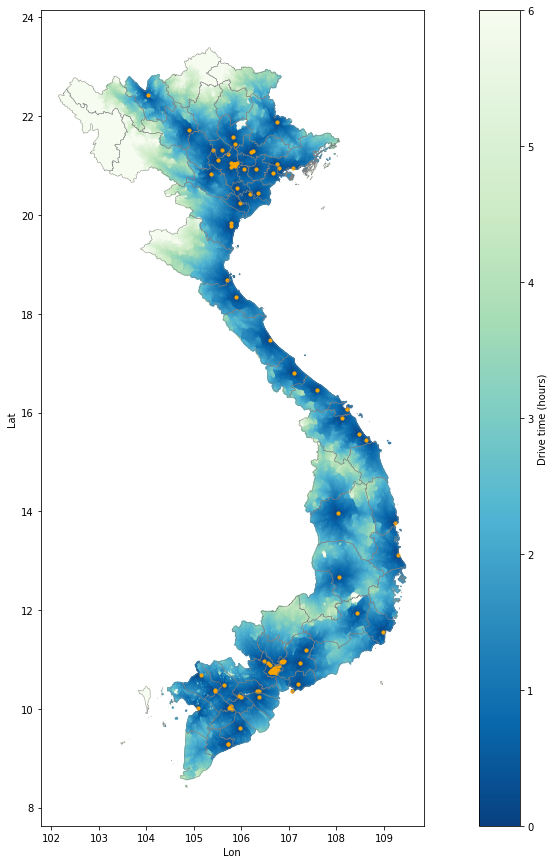

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
vn_map = vn_prov.boundary.plot(ax=ax, color='gray', linewidth=0.4)
gdf.plot(ax=ax, markersize=0.5, column='min_drive',
         legend=True,
         legend_kwds={'label': "Drive time (hours)"},
         cmap='GnBu_r')
stroke_data.plot.scatter(ax=ax, x='Lon', y='Lat', s=10, color='orange')

We can also overlay the isochrone map with serving population value for each facility:

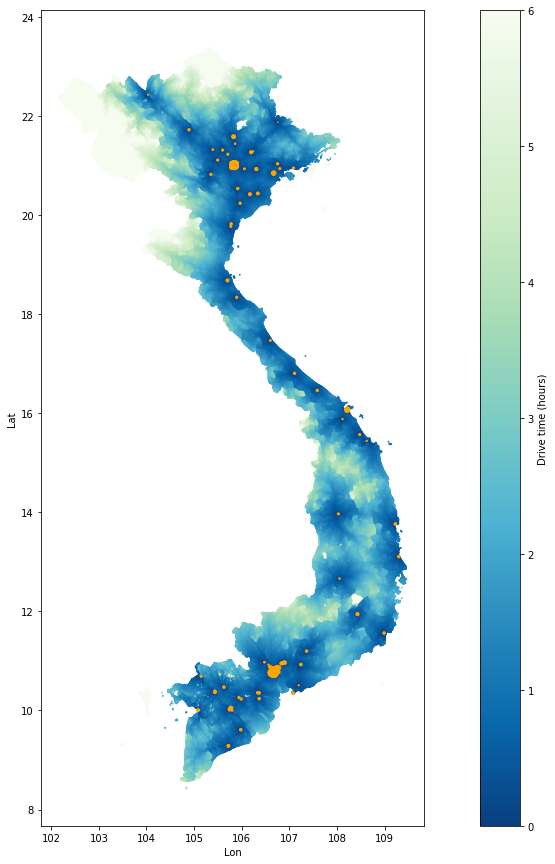

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
# vn_map = vn_prov.boundary.plot(ax=ax, color='gray')
gdf.plot(ax=ax, markersize=0.5, column='min_drive',
         legend=True,
         legend_kwds={'label': "Drive time (hours)"},
         cmap='GnBu_r')
flood_facs_w_pop.plot.scatter(ax=ax, x='Lon', y='Lat',
                              s='Pop_2020', color='orange')